# Load packages and set global settings

Imports and set up paths for output data.

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from estimator_v1 import Estimator
from models_v1 import build_nonlinear_model, build_linear_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt
import os
from sklearn.metrics import r2_score

print(sc.__version__)
print(anndata.__version__)

np.random.seed(seed=42)

1.10.3
0.10.9


In [2]:
# current working dir
root_dir = './'

# set output paths
results_dir = root_dir + 'results/'
dir_out = results_dir + 'figures/'
dir_anndata = results_dir + 'anndata/'
dir_tfmatrix = results_dir + 'csv/'
model_dir = './results/model/'

# Load data

Read the anndata object and 48TF matrix which will be used as labels and features in machine learning model respectively.

In [3]:
# read adata object and 48TF matrix
adata_obj_path = dir_anndata + 'adata_assigned_filtered.h5ad'
tf_matrix_path = dir_tfmatrix + 'tfmatrix_assigned_filtered.csv'


adata_obj = sc.read_h5ad(adata_obj_path)  
tf_matrix = pd.read_csv(tf_matrix_path, index_col=0)

print("read adata and TF matrix info sucessfully.")
print(f"AnnData shape: {adata_obj.shape}")
print(f"TF matrix shape: {tf_matrix.shape}")

read adata and TF matrix info sucessfully.
AnnData shape: (26764, 36745)
TF matrix shape: (26764, 48)


# Predict 3000 HVGs

Instead of performing specific cell-type predictions as we've done in predict_00.ipynb, the current task aims to predict the expression levels of 3000 highly variable genes (3000 HVGs), which represents a more complex prediction problem as it transforms the task into a high-dimensional multi-output prediction task.

We've tried both non-linear model and linear model to capture the relationships between the input TF combinations and the 3000 HVGs expression outputs for each cell. We also compare the predictive performances for both models. 

## Non-linear model

### Prepare dataset and model architecture

In [4]:
est_hvg = Estimator(X_base=tf_matrix, Y_base=adata_obj)

est_hvg.set_task(task="regression", hvg=True, hvg_n_genes=3000)
print(f"  Input X shape (TFs): {est_hvg.x.shape}")
print(f"  Output Y shape (HVGs): {est_hvg.y.shape}")

est_hvg.split_dataset(test_size=0.1, random_state=42)

n_inputs = est_hvg.x.shape[1]
n_outputs = est_hvg.y.shape[1]

print("initializing model...")
est_hvg.init_model("nonlinear_model", n_inputs=n_inputs, n_outputs=n_outputs, hidden_units=[128, 64])

  Input X shape (TFs): (26764, 48)
  Output Y shape (HVGs): (26764, 3000)
initializing model...


### Train model with tuning

In [5]:
# define hypermodel_builder required by KerasTuner 
def build_nonlinear_hypermodel(hp):
    
    n_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    hidden_units = []
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        hidden_units.append(units)
    lr = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')
    model = build_nonlinear_model(
        n_inputs=n_inputs,
        n_outputs=n_outputs,
        hidden_units=hidden_units
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

tuning_callbacks = [
    EarlyStopping(monitor='val_loss', # monitoring validation set loss
                  patience=10,        # early stopping if there is no improvement after 10 epochs
                  verbose=1,          
                  mode='min',        # aim to minimize losses
                  restore_best_weights=False 
                 )
]

print("\nStarting tuning...")
est_hvg.tune_tf(
    hypermodel_builder=build_nonlinear_hypermodel,
    max_trials=10,
    epochs=50,       
    overwrite=True,
    validation_split=0.1, 
    callbacks=tuning_callbacks 
)

Trial 10 Complete [00h 04m 13s]
val_loss: 0.07279941439628601

Best val_loss So Far: 0.05208393558859825
Total elapsed time: 00h 27m 28s
Tuning complete. Best hyperparameters found: {'num_layers': 1, 'units_0': 192, 'learning_rate': 0.0012862858911930303, 'units_1': 64, 'units_2': 256}
Best hyperparameters set. Model is ready to be trained.



Training final model using best hyperparameters found...
Model is already compiled.
Epoch 1/100
337/339 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0771 - mae: 0.1025
Epoch 1: val_loss improved from inf to 0.05525, saving model to ./results/model/non_linear.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0770 - mae: 0.1024 - val_loss: 0.0553 - val_mae: 0.0937 - learning_rate: 0.0013
Epoch 2/100
333/339 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0547 - mae: 0.0932
Epoch 2: val_loss improved from 0.05525 to 0.05473, saving model to ./results/model/non_linear.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0547 - mae: 0.0932 - val_loss: 0.0547 - val_mae: 0.0939 - learning_rate: 0.0013
Epoch 3/100
334/339 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0540 - mae: 0.0929
Epoch 3: val_loss improved from 0.05473 to 0.05433, saving model to ./results/model/non_linear.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0540 - mae: 0.0929 - val_loss: 0.0543 - val_mae: 0.0927 -

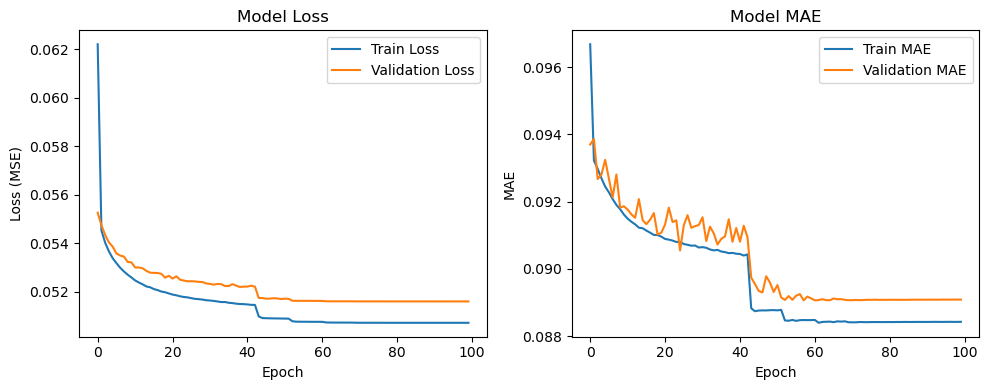

In [6]:
final_training_callbacks = [
    EarlyStopping(monitor='val_loss',
                  patience=20, # Give final training more patience
                  verbose=1,
                  mode='min',
                  restore_best_weights=True # Restore best weights at the end
                 ),
    ModelCheckpoint(filepath=model_dir+'non_linear.keras',
                    monitor='val_loss',
                    save_best_only=True, # Only save the best model
                    save_weights_only=False,
                    mode='min',
                    verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.2,
                      patience=8,
                      min_lr=1e-6,
                      mode='min',
                      verbose=1)
]

print("\nTraining final model using best hyperparameters found...")

history = est_hvg.train(
        epochs=100,             
        batch_size=64,          
        validation_split=0.1,   
        callbacks=final_training_callbacks 
    )

# view training history
if history:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    history_fig_path = os.path.join(dir_out, "hvg_regression_training_history.png")
    plt.savefig(history_fig_path, dpi=300)
    print(f"Training history plot saved to: {history_fig_path}")


In [7]:
best_model_path = model_dir+'non_linear.keras'
est_hvg.model = tf.keras.models.load_model(best_model_path)

print("✓ Best model loaded.")

✓ Best model loaded.


### Evaluate model

In [8]:
print("\nEvaluating model on the unseen test set...")
results, predictions = est_hvg.evaluate(return_predictions=True)

print("\nEvaluation results on the test set:")
for metric, value in results.items():
    print(f"  Test {metric}: {value:.4f}")


Evaluating model on the unseen test set...
Test loss: 0.0511
Test compile_metrics: 0.0887
Generating predictions on 2677 test samples...
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Evaluation results on the test set:
  Test loss: 0.0511
  Test compile_metrics: 0.0887


### Downstream analysis

In [9]:
# calculate r2 score between predicted data and true data
if predictions is not None and est_hvg.Y_test is not None:
    y_true = est_hvg.Y_test
    y_pred = predictions
    num_genes = y_true.shape[1] 
    per_gene_r2 = r2_score(y_true, y_pred, multioutput='raw_values')

# R² Statistics
print(f"\nR² Statistics:")
print(f"  Mean:   {np.mean(per_gene_r2):.4f}")
print(f"  Median: {np.median(per_gene_r2):.4f}")
print(f"  Std:    {np.std(per_gene_r2):.4f}")
print(f"  Min:    {np.min(per_gene_r2):.4f}")
print(f"  Max:    {np.max(per_gene_r2):.4f}")
print(f"\nGenes with R² > 0.3: {np.sum(per_gene_r2 > 0.3)} ({np.sum(per_gene_r2 > 0.3)/num_genes*100:.1f}%)")
print(f"Genes with R² > 0.5: {np.sum(per_gene_r2 > 0.5)} ({np.sum(per_gene_r2 > 0.5)/num_genes*100:.1f}%)")


R² Statistics:
  Mean:   0.0736
  Median: 0.0217
  Std:    0.1080
  Min:    -0.0806
  Max:    0.6151

Genes with R² > 0.3: 165 (5.5%)
Genes with R² > 0.5: 19 (0.6%)


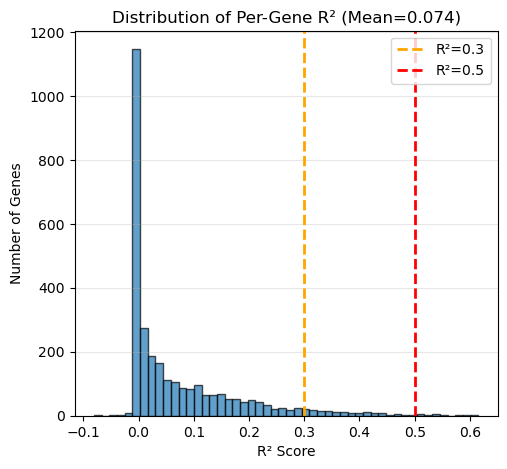

In [10]:
# plot the distribution of R2 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(per_gene_r2, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='R²=0.3')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='R²=0.5')
plt.xlabel('R² Score')
plt.ylabel('Number of Genes')
plt.title(f'Distribution of Per-Gene R² (Mean={np.mean(per_gene_r2):.3f})')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(f'{dir_out}/nl_distreibution_r2.png', dpi=300)

In [11]:
# inspect high R2 score value genes
high_r2_threshold = 0.5
high_r2_indices = np.where(per_gene_r2 > high_r2_threshold)[0]
high_r2_genes = adata_obj.var_names[high_r2_indices]
high_r2_scores = per_gene_r2[high_r2_indices]

# sort by R2
sorted_idx = np.argsort(high_r2_scores)[::-1]  
high_r2_genes_sorted = high_r2_genes[sorted_idx]
high_r2_scores_sorted = high_r2_scores[sorted_idx]

# show results
high_r2_df = pd.DataFrame({
    'Gene': high_r2_genes_sorted,
    'R2_Score': high_r2_scores_sorted
})

print(f"\nGenes with R² > {high_r2_threshold} (n={len(high_r2_genes)})")
print(high_r2_df.to_string(index=False))


Genes with R² > 0.5 (n=19)
    Gene  R2_Score
    ASPH  0.615052
  CACHD1  0.605357
    CD83  0.596240
   BSPH1  0.591544
     AK8  0.587177
   ADCY9  0.579941
     AIP  0.553250
C11orf16  0.544251
    BRAF  0.540920
   AGMAT  0.535864
     AMH  0.532116
   ADCY4  0.528915
    CD1B  0.520571
    CD22  0.520477
C19orf47  0.511000
  ATP5MF  0.508942
    CA14  0.507545
   AGFG1  0.506273
   ATF6B  0.500696


##  Linear model

### Prepare dataset and model architecture

In [12]:
est_hvg_ln = Estimator(X_base=tf_matrix, Y_base=adata_obj)

est_hvg_ln.set_task(task="regression", hvg=True, hvg_n_genes=3000)
print(f"  Input X shape (TFs): {est_hvg_ln.x.shape}")
print(f"  Output Y shape (HVGs): {est_hvg_ln.y.shape}")

est_hvg_ln.split_dataset(test_size=0.1, random_state=42)

n_inputs_ln = est_hvg_ln.x.shape[1]
n_outputs_ln = est_hvg_ln.y.shape[1]

print("initializing model...")
est_hvg_ln.init_model("linear_model", n_inputs=n_inputs_ln, n_outputs=n_outputs_ln)

  Input X shape (TFs): (26764, 48)
  Output Y shape (HVGs): (26764, 3000)
initializing model...


### Train model with tuning

In [13]:
def build_linear_hypermodel_hvg(hp):
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    model = build_linear_model(n_inputs=n_inputs_ln, n_outputs=n_outputs_ln)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=['mae'])
    return model

tuning_callbacks_ln = [EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')]

print("\nstart tuning (tune_tf) for linear model...")
project_name_ln = f'tune_{est_hvg_ln.model_name}_hvg'
est_hvg_ln.tune_tf(
    hypermodel_builder=build_linear_hypermodel_hvg,
    max_trials=10,
    epochs=50,
    overwrite=True,
    validation_split=0.1,
    callbacks=tuning_callbacks_ln,
    project_name=project_name_ln 
)

Trial 10 Complete [00h 02m 37s]
val_loss: 0.0636112242937088

Best val_loss So Far: 0.05281854420900345
Total elapsed time: 00h 21m 15s
Tuning complete. Best hyperparameters found: {'learning_rate': 0.00013665992053820878}
Best hyperparameters set. Model is ready to be trained.



Training final model using best hyperparameters found...
Model is already compiled.
Epoch 1/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1430 - mae: 0.1203 - val_loss: 0.1192 - val_mae: 0.1159
Epoch 2/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1151 - mae: 0.1143 - val_loss: 0.1061 - val_mae: 0.1115
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1037 - mae: 0.1105 - val_loss: 0.0987 - val_mae: 0.1086
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0974 - mae: 0.1080 - val_loss: 0.0936 - val_mae: 0.1070
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0920 - mae: 0.1062 - val_loss: 0.0896 - val_mae: 0.1052
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0884 - mae: 0.1045 - val_loss: 0.0863 - val_mae: 0.1039
Epoch 7/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0855 - mae: 0.1035 - val_loss: 0.0835 - val_mae: 0.1028
Epoch 8/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0830 - mae: 0.1026 

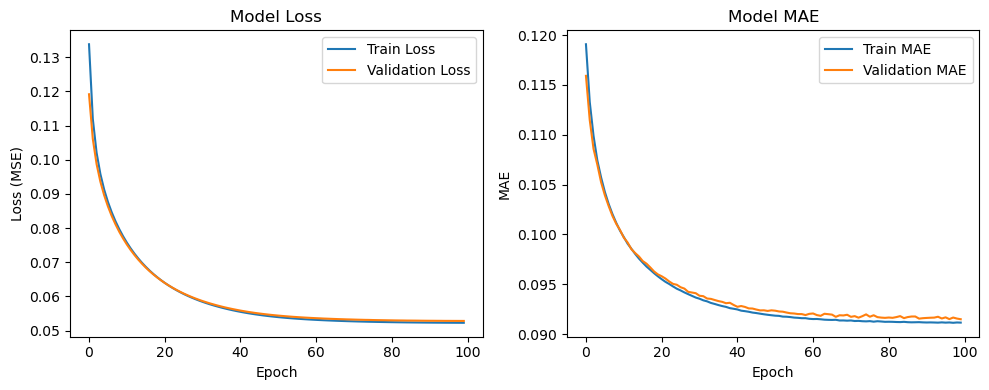

In [14]:
final_callbacks_ln = [
    EarlyStopping(monitor='val_loss',
                  patience=20,
                  verbose=1,
                  mode='min',
                  restore_best_weights=True),
    ModelCheckpoint(filepath=model_dir+'linear.keras',
                    monitor='val_loss', 
                    save_best_only=True,
                    mode='min',
                    verbose=0)
]

print("\nTraining final model using best hyperparameters found...")
history_ln = est_hvg_ln.train(
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=final_callbacks_ln, verbose=1
)

# view training history
if history_ln:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_ln.history['loss'], label='Train Loss')
    plt.plot(history_ln.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    if 'mae' in history_ln.history:
        plt.subplot(1, 2, 2)
        plt.plot(history_ln.history['mae'], label='Train MAE')
        plt.plot(history_ln.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
    
    plt.tight_layout()
    history_ln_fig_path = os.path.join(dir_out, "hvg_regression_training_history_ln.png")
    plt.savefig(history_ln_fig_path, dpi=300)
    print(f"Training history plot saved to: {history_ln_fig_path}")


In [15]:
best_model_ln_path = model_dir+'linear.keras'
est_hvg_ln.model = tf.keras.models.load_model(best_model_ln_path)

print("✓ Best model loaded.")

✓ Best model loaded.


### Evaluation

In [16]:
print("\nEvaluating model on the unseen test set...")
results_ln, predictions_ln = est_hvg_ln.evaluate(return_predictions=True)

print("\nEvaluation results on the test set:")
for metric, value in results_ln.items():
    print(f"  Test {metric}: {value:.4f}")


Evaluating model on the unseen test set...
Test loss: 0.0524
Test compile_metrics: 0.0912
Generating predictions on 2677 test samples...
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Evaluation results on the test set:
  Test loss: 0.0524
  Test compile_metrics: 0.0912


### Downstream analysis

In [17]:
if predictions_ln is not None and est_hvg_ln.Y_test is not None:
    y_true_ln = est_hvg_ln.Y_test
    y_pred_ln = predictions_ln
    num_genes_ln = y_true_ln.shape[1]
    per_gene_r2_ln = r2_score(y_true_ln, y_pred_ln, multioutput='raw_values')

print(f"\nR² Statistics:")
print(f"  Mean:   {np.mean(per_gene_r2_ln):.4f}")
print(f"  Median: {np.median(per_gene_r2_ln):.4f}")
print(f"  Std:    {np.std(per_gene_r2_ln):.4f}")
print(f"  Min:    {np.min(per_gene_r2_ln):.4f}")
print(f"  Max:    {np.max(per_gene_r2_ln):.4f}")
print(f"\nGenes with R² > 0.3: {np.sum(per_gene_r2_ln > 0.3)} ({np.sum(per_gene_r2_ln > 0.3)/num_genes_ln*100:.1f}%)")
print(f"Genes with R² > 0.5: {np.sum(per_gene_r2_ln > 0.5)} ({np.sum(per_gene_r2_ln > 0.5)/num_genes_ln*100:.1f}%)")


R² Statistics:
  Mean:   0.0621
  Median: 0.0220
  Std:    0.1007
  Min:    -0.7204
  Max:    0.5929

Genes with R² > 0.3: 116 (3.9%)
Genes with R² > 0.5: 12 (0.4%)


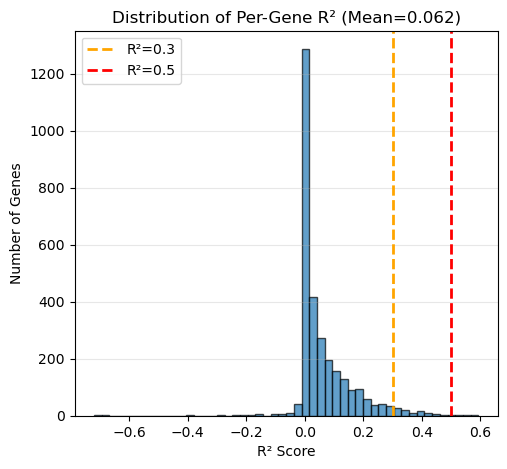

In [18]:
# plot the distribution of R2 

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(per_gene_r2_ln, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='R²=0.3')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='R²=0.5')
plt.xlabel('R² Score')
plt.ylabel('Number of Genes')
plt.title(f'Distribution of Per-Gene R² (Mean={np.mean(per_gene_r2_ln):.3f})')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig(f'{dir_out}/l_distreibution_r2.png', dpi=300)

In [19]:
# inspect high R2 score value genes
high_r2_threshold=0.5
high_r2_indices_ln = np.where(per_gene_r2_ln > high_r2_threshold)[0]
high_r2_genes_ln = adata_obj.var_names[high_r2_indices_ln]
high_r2_scores_ln = per_gene_r2_ln[high_r2_indices_ln]

# sort by R2
sorted_idx_ln = np.argsort(high_r2_scores_ln)[::-1]  
high_r2_genes_sorted_ln = high_r2_genes_ln[sorted_idx_ln]
high_r2_scores_sorted_ln = high_r2_scores_ln[sorted_idx_ln]

# show results
high_r2_df_ln = pd.DataFrame({
    'Gene': high_r2_genes_sorted_ln,
    'R2_Score': high_r2_scores_sorted_ln
})

print(f"\nGenes with R² > {high_r2_threshold} (n={len(high_r2_genes_ln)})")
print(high_r2_df_ln.to_string(index=False))


Genes with R² > 0.5 (n=12)
    Gene  R2_Score
     AMH  0.592893
    CD83  0.587286
    ASPH  0.586346
  CACHD1  0.575630
   BSPH1  0.555115
   ADCY9  0.546548
     AK8  0.540399
   CADM1  0.528001
    BRAF  0.520976
C11orf16  0.508626
     AIP  0.505795
    CD22  0.502533


# non-linear model VS linear model

In [20]:
genes = adata_obj.var_names[:est_hvg_ln.y.shape[1]]  

# linear model
r2_ln = per_gene_r2_ln

# non-linear model
r2_nl = per_gene_r2

# R² > 0.5 genes in 3000hvgs
genes_ln_high = set(genes[r2_ln > 0.5])
genes_nl_high = set(genes[r2_nl > 0.5])

print(f"Linear model genes R²>0.5: {len(genes_ln_high)}")
print(f"Non-linear model genes R²>0.5: {len(genes_nl_high)}")

Linear model genes R²>0.5: 12
Non-linear model genes R²>0.5: 19


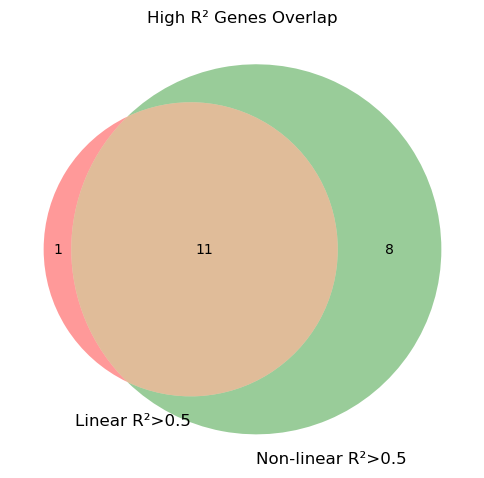

In [21]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
venn2([genes_ln_high, genes_nl_high], 
      set_labels=('Linear R²>0.5', 'Non-linear R²>0.5'))
plt.title("High R² Genes Overlap")
plt.savefig(f'{dir_out}/high_r2_genes_ovl.png', dpi=300)
plt.show()
